# Gaussian Processes in Python

You might be wondering, what exactly are Gaussian processes, and why should you care?  In a nutshell, gaussian processes are one of the most elegant techniques in existence for modeling data.  Gaussian processes can be used for regression, classification, filtering and interpolation.  Unlike many machine learning techniques, Gaussian processes provide information on the distribution of possible outcomes, rather than a single maximum likelihood estimate.  They are capable of producing nearly parameter free models, but they can also be augmented with via the specification of as many parameters as desired.  This allows you to iteratively refine a Gaussian process model as your knowledge grows.

You might be wondering, why aren't the the hot thing if they're so powerful?  The main reason is that Gaussian processes are slow to compute, so they're not compatible with the current big data trend.  In fact, with traditional Gaussian process methods, you can't work with more than a few thousand data points at a time.  Thankfully, variants of the Gaussian process model have been created that scale well to millions of data points and beyond.

While there is a lot of fancy math behind Gaussian processes, ultimate what they do is model how a function value changes as its inputs change.  To put them in perspective, another name for Gaussian processes is kriging.  Kriging allows mining companies to quickly predict yield for a property using a few broadly spaced samples.

Gaussian processes are specified by a mean function and a covariance function.  In practice the mean function is usually ignored by fixing it at zero, and the entire model is specified using the covariance function.  The covariance function describes how the Gaussian process varies from one point to the next.  Given this, you can extrapolate trends from your data.  The covariance function is a probabilistic kernel that takes two points in feature space and produces a measure of similarity.  Being probabalistic, these kernels have the nifty property that they can be added or multiplied together and the result is also a valid kernel.  This lets you build complex kernels to precisely model behavior.  This might be a little bit confusing so let's move forward with some examples to ground things.

I prefer the GPy package for building gaussian processes.  It has lots of great features that aren't available in other packages.  The only downside is that it currently does not have very good GPU support.

In [1]:
import numpy as np
import pandas as pd
import GPy
from matplotlib import pyplot as plt
from numpy.random import randn
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
x = np.linspace(0, 10, 100)
y_sin = np.sin(x*1.5)
y_log = np.log2(x + 1)
y_pow = np.power(x, 1.25)
y_tanh = np.tanh(x)
y_step = np.array([1] * 25 + [0] * 50 + [1] * 25)
np.random.seed(4096)
noise = np.random.randn(*x.shape)

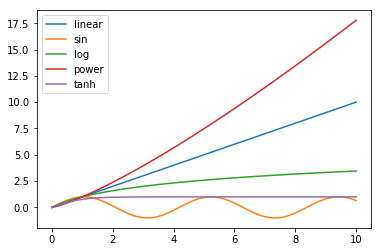

In [3]:
fig, ax = plt.subplots()

ax.plot(x, x, label="linear")
ax.plot(x, y_sin, label="sin")
ax.plot(x, y_log, label="log")
ax.plot(x, y_pow, label="power")
ax.plot(x, y_tanh, label="tanh")

ax.legend();

## The linear case

Building linear models of your data is hopefully something you're already familiar with.  Gaussian Processes can be used to build models of this sort with some nice additional properties.

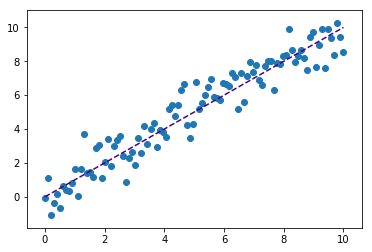

In [4]:
fig, ax = plt.subplots()

ax.plot(x, x, color="indigo", linestyle="--")
ax.scatter(x, x + noise);

### Linear Kernel

There are several ways to model this with a Gaussian Process.  They primarily differ in how they handle inference when in areas of low evidence.  To produce Bayesian linear regression, you can use a linear kernel.

In [5]:
gp_x = x.reshape(x.shape[0], 1)
gp_y = (x + noise).reshape(x.shape[0], 1)

lin_kernel = GPy.kern.Linear(1)
lin_model = GPy.models.GPRegression(gp_x, gp_y, lin_kernel)
lin_model.optimize()

In [6]:
lin_model

GP_regression.,value,constraints,priors
linear.variances,1.01921672908,+ve,
Gaussian_noise.variance,0.767055693878,+ve,


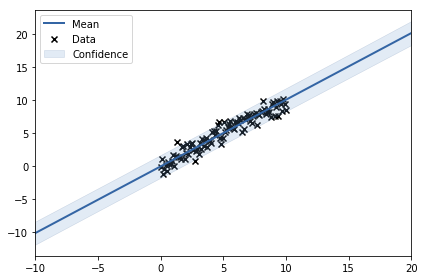

In [7]:
lin_model.plot([-10, 20]);

### Radial Basis Function Kernel

In this case, the linear kernel is obviously the right choice, but that is not always the case.  In many cases a function is likely to revert to its mean outside the range of observations.  One way to model this linear behavior with reversion is with a squared exponential radial basis functions (RBF).  Radial basis functions can map to arbitrarily curved functions, and the variance of their estimates grows quickly outside the range of observations.

GP_regression.,value,constraints,priors
rbf.variance,69.872816106,+ve,
rbf.lengthscale,12.7284077174,+ve,
Gaussian_noise.variance,0.708019503075,+ve,


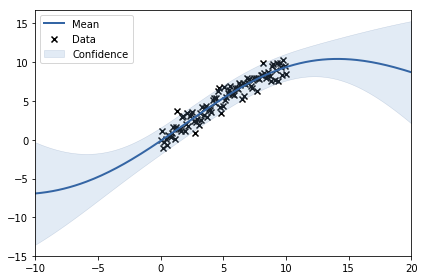

In [8]:
kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(gp_x, gp_y, kernel)
model.optimize()
model.plot([-10, 20])
model

You can see that the predictions quickly become less certain and revert slowly towards the mean function value (0 by default) the farther you get from observations.  These are very nice features in general, so the RBF kernel will usually be preferable to the linear kernel unless you are certain a relationship is perfectly linear.

### The Multi-layer Perceptron (MLP) kernel

This is another really useful kernel.  This kernel is good for modelling processes that have long periods of slow change punctuated by brief periods of rapid change.  One nice feature of this kernel is that predictions at the fringes tend to follow the local trend of the data.  Because of this it approximates a simple linear model when the data supports it, while providing support for discontinuities.  This flexibility comes at the cost additional parameters for your model.

GP_regression.,value,constraints,priors
mlp.variance,414.109004891,+ve,
mlp.weight_variance,0.00293917321408,+ve,
mlp.bias_variance,3.7697339535e-27,+ve,
Gaussian_noise.variance,0.708970169768,+ve,


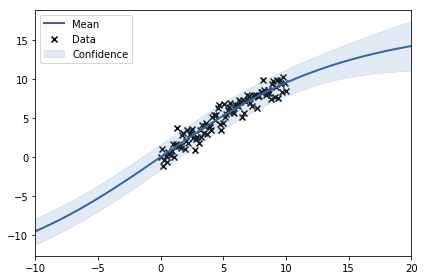

In [9]:
kern = GPy.kern.MLP(1)
model = GPy.models.GPRegression(gp_x, gp_y, kern)
model.optimize()
model.plot([-10, 20])
model

This tight linear relationship is learned from the data, rather than a constraint of our model.

## The simple periodic case

A lot of real world data is periodic.  There are a variety of approaches to handling periodic data.

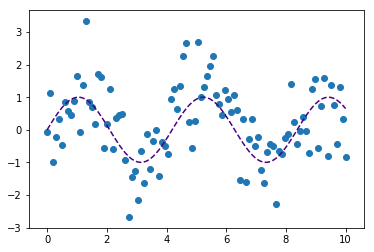

In [10]:
fig, ax = plt.subplots()

ax.plot(x, y_sin, color="indigo", linestyle="--")
ax.scatter(x, y_sin + noise);

In the one dimensional case, it is easy to tell if data is periodic.  For real data, it can be more challenging.  RBFs provide a reasonable model under conditions of ignorance.

GP_regression.,value,constraints,priors
rbf.variance,0.744986584574,+ve,
rbf.lengthscale,0.883064089203,+ve,
Gaussian_noise.variance,0.707758462864,+ve,


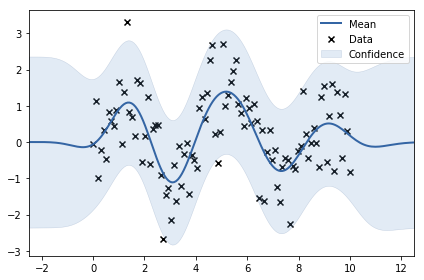

In [11]:
gp_y_2 = (y_sin + noise).reshape(x.shape[0], 1)

kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(gp_x, gp_y_2, kernel)
model.optimize()
model.plot()
model

### Periodic Matern Kernel

This kernel models processes that vary smoothly in time with some periodic component.  Let's take a look at how it handles identifying a noisy sin wave.

GP_regression.,value,constraints,priors
periodic_Matern52.variance,4.37447657101,+ve,
periodic_Matern52.lengthscale,1.59274877027,+ve,
periodic_Matern52.period,7.92024027428,+ve,
Gaussian_noise.variance,0.727664155179,+ve,


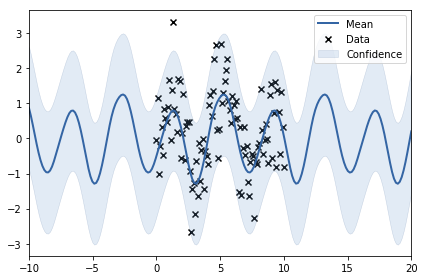

In [12]:
per_mat_kern = GPy.kern.PeriodicMatern52(1)
per_mat_model = GPy.models.GPRegression(gp_x, gp_y_2, per_mat_kern)
per_mat_model.optimize()
per_mat_model.plot([-10, 20])
per_mat_model

## Trending periodic

Now for something a little more challenging.  Here we'll combine a linear trend with periodic modulation.

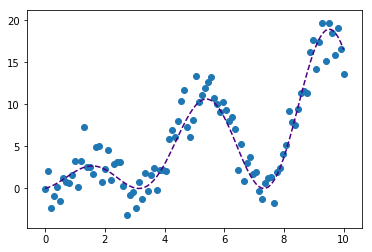

In [13]:
fig, ax = plt.subplots()

ax.plot(x, x * (1 + y_sin), color="indigo", linestyle="--")
ax.scatter(x, x * (1 + y_sin) + noise * 2);

gp_y_3 = (x * (1 + y_sin) + noise * 2).reshape(x.shape[0], 1)

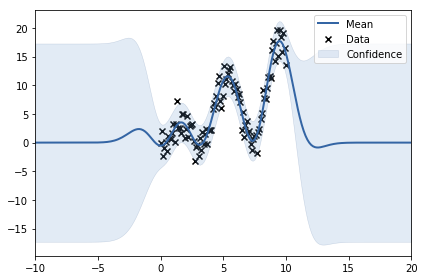

In [14]:
rbf_3_model = GPy.models.GPRegression(gp_x, gp_y_3, GPy.kern.RBF(1))

rbf_3_model.optimize()
rbf_3_model.plot([-10, 20]);

The RBF model doesn't provide you much information in this case.  Let's compare it to the more versatile MLP kernel.

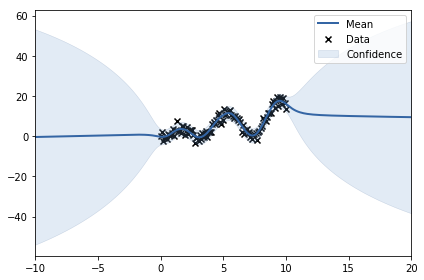

In [15]:
mlp_kern = GPy.kern.MLP(1)
mlp_model = GPy.models.GPRegression(gp_x, gp_y_3, mlp_kern)
mlp_model.optimize()
mlp_model.plot([-10, 20]);

The MLP model looks slightly better from a mean average error standpoint.  It still isn't very good in terms of learning the structure of the data.  If you want to improve your model you have to create new kernels that capture the covariance structure of your data.  Thankfully, creating new kernels is quite easy.

### Combining Kernels

One nice feature of kernels is that they can be combined via addition and multiplication to form new kernels.  This allows you to easily specify nuanced models. Kernels produced by addition are high in density where either input kernel was high, like an OR operation.  Kernels produced by multiplication are high where both input kernels are high, like an AND operation.

Another useful view is that kernels addition generalizes a model, while kernel multiplication constrains it.

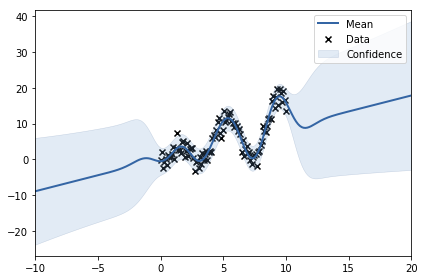

In [16]:
kern =  GPy.kern.Linear(1) + GPy.kern.RBF(1)
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)

model.optimize()
model.plot([-10, 20]);

Here you have accurate RBF approximation within the range of observations, transitioning to linear approximation when outside that range.  This kernel combination is better than either one alone, and is robust enough to handle most data.  That makes it a good default kernel.

As an amusing parlor trick, you can use kernel products to perform Bayesian polynomial regression.

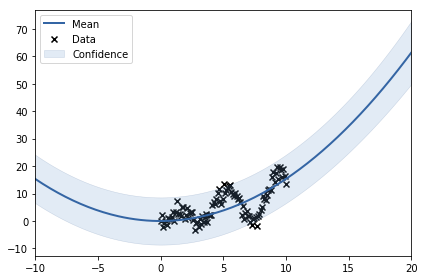

In [17]:
kern =  GPy.kern.Linear(1) * GPy.kern.Linear(1)
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)

model.optimize()
model.plot([-10, 20]);

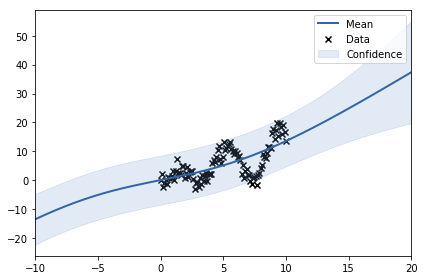

In [34]:
kern =  GPy.kern.MLP(1) + GPy.kern.Linear(1)
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)

model.optimize()
model.plot([-10, 20]);

#### Over-learning

Kernels sometimes learn high variance paramter settings that cause the posterior predictive distribution to explode outside the range of observation.  These cases are easy to spot in low dimensional data, but higher dimensions increase the challenge significantly.  These high variance kernels are useless on their own, but they can be useful when constrained by a simple kernel, such as a linear kernel, or an RBF with an extremely long lengthscale.

GP_regression.,value,constraints,priors
sum.periodic_Matern52.variance,69.0503764314,+ve,
sum.periodic_Matern52.lengthscale,1.74810220004,+ve,
sum.periodic_Matern52.period,36.6969381933,+ve,
sum.mlp.variance,48.5292676959,+ve,
sum.mlp.weight_variance,0.24147450538,+ve,
sum.mlp.bias_variance,5.72287227907,+ve,
Gaussian_noise.variance,2.87780466013,+ve,


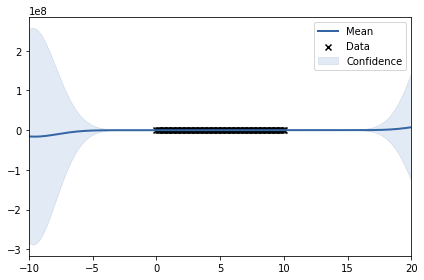

In [36]:
kern = GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(1)
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)


model.optimize()
model.plot([-10, 20])
model

First we'll use a RBF to restrict it.  Notice I'm giving the optimizer a hint here by setting the lengthscale to 25.

GP_regression.,value,constraints,priors
mul.rbf.variance,3443.4399189,+ve,
mul.rbf.lengthscale,1827.05349719,+ve,
mul.sum.periodic_Matern52.variance,0.0125928612662,+ve,
mul.sum.periodic_Matern52.lengthscale,1.50542688493,+ve,
mul.sum.periodic_Matern52.period,10.7860056627,+ve,
mul.sum.mlp.variance,11766.0438086,+ve,
mul.sum.mlp.weight_variance,5.3275584756e-08,+ve,
mul.sum.mlp.bias_variance,5.56268464627e-309,+ve,
Gaussian_noise.variance,2.864359336,+ve,


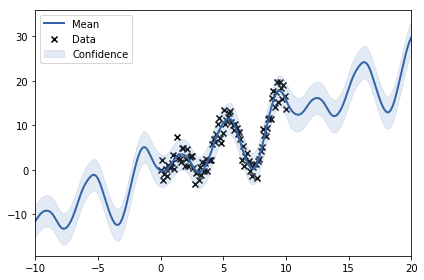

In [37]:
kern = GPy.kern.RBF(1, lengthscale=25) * (GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(1))
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)


model.optimize()
model.plot([-10, 20])
model

By adding the periodic matern kernel and the MLP kernel, you can improve your approximation of the function.

GP_regression.,value,constraints,priors
mul.linear.variances,0.000208665144601,+ve,
mul.sum.mlp.variance,5232.78705916,+ve,
mul.sum.mlp.weight_variance,621840.432493,+ve,
mul.sum.mlp.bias_variance,5.56268464627e-309,+ve,
mul.sum.periodic_Matern52.variance,40846.5439572,+ve,
mul.sum.periodic_Matern52.lengthscale,2.25295312819,+ve,
mul.sum.periodic_Matern52.period,8.02182619592,+ve,
Gaussian_noise.variance,2.82205122129,+ve,


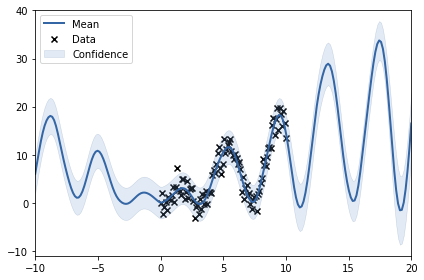

In [21]:
kern = GPy.kern.Linear(1) * (GPy.kern.MLP(1) + GPy.kern.PeriodicMatern52(1))
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)
model.optimize()
model.plot([-10, 20])
model

GP_regression.,value,constraints,priors
mul.sum.rbf.variance,5.18827027961,+ve,
mul.sum.rbf.lengthscale,2531.22168062,+ve,
mul.sum.periodic_Matern52.variance,40.0246258194,+ve,
mul.sum.periodic_Matern52.lengthscale,2.24945691447,+ve,
mul.sum.periodic_Matern52.period,8.02170984099,+ve,
mul.linear.variances,0.211714890251,+ve,
Gaussian_noise.variance,2.82203546367,+ve,


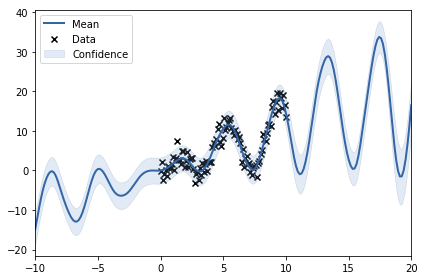

In [22]:
kern = (GPy.kern.RBF(1, lengthscale=10) + GPy.kern.PeriodicMatern52(1, variance=2)) * GPy.kern.Linear(1)
model = GPy.models.GPRegression(gp_x, gp_y_3, kern)


model.optimize()
model.plot([-10, 20])
model

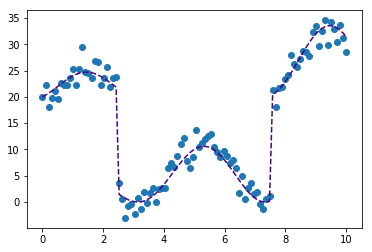

In [23]:
fig, ax = plt.subplots()

y_jump = (y_log * 2 * (1 + y_sin) + 20 * y_step)
ax.scatter(x, y_jump + 2 * noise)
ax.plot(x, y_jump, linestyle='--', color="indigo");

gp_y_4 = (y_jump + 2 * noise).reshape(x.shape[0], 1)

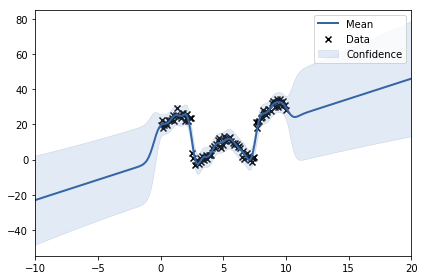

In [24]:
model = GPy.models.GPRegression(gp_x, gp_y_4, GPy.kern.RBF(1) + GPy.kern.Linear(1))
model.optimize()
model.plot([-10, 20]);

GP_regression.,value,constraints,priors
mlp.variance,1455.44169119,+ve,
mlp.weight_variance,99.4449932718,+ve,
mlp.bias_variance,10263.7798775,+ve,
Gaussian_noise.variance,4.88116848692,+ve,


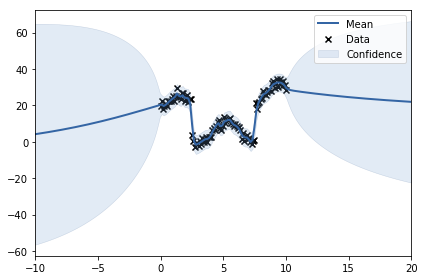

In [25]:
model = GPy.models.GPRegression(gp_x, gp_y_4, GPy.kern.MLP(1))
model.optimize()
model.plot([-10, 20])
model

GP_regression.,value,constraints,priors
sum.periodic_Matern52.variance,205.242922237,+ve,
sum.periodic_Matern52.lengthscale,0.677033328567,+ve,
sum.periodic_Matern52.period,7.86737848144,+ve,
sum.rbf.variance,223.331255157,+ve,
sum.rbf.lengthscale,22.4138393351,+ve,
Gaussian_noise.variance,6.12940556522,+ve,


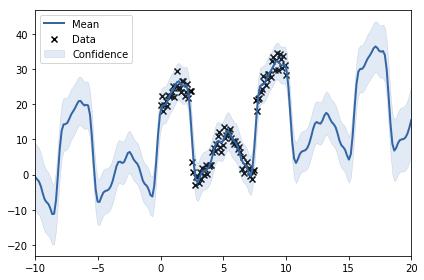

In [26]:
kern = GPy.kern.PeriodicMatern52(1) + GPy.kern.RBF(1, lengthscale=10)
model = GPy.models.GPRegression(gp_x, gp_y_4, kern)
model.optimize()
model.plot([-10, 20])
model

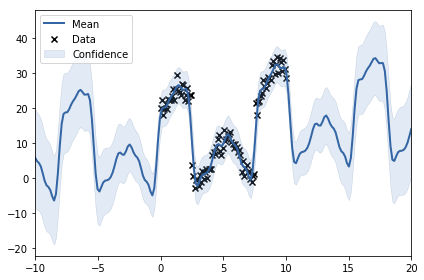

In [27]:
kern = GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(1)
model = GPy.models.GPRegression(gp_x, gp_y_4, kern)
model.optimize()
model.plot([-10, 20]);

### Fixed Kernels

It is also possible that the low portion of this data is just a local error.  We can model this hypothesis using a fixed kernel.  The fixed kernel allows you to adjust the influence of individual data points on the final model.  The most common reason to do this is when you're combining data from multiple sources.

Note the addition of the bias kernel.  The bias kernel in combination with the RBF reverts to the mean of the data rather than 0 when far from the observed range.

GP_regression.,value,constraints,priors
sum.rbf.variance,97.5769623438,+ve,
sum.rbf.lengthscale,0.483834738521,+ve,
sum.fixed.variance,3.49559702792e-08,+ve,
sum.bias.variance,246.718960278,+ve,
Gaussian_noise.variance,6.76055456612,+ve,


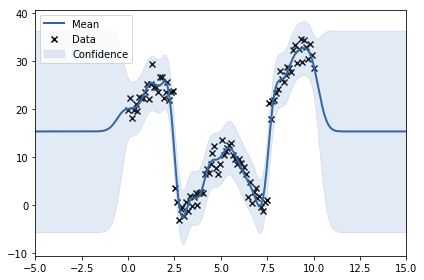

In [28]:
prior = GPy.priors.Gamma.from_EV(5, 5)

input_std = np.diag(np.power((-y_step + 1) * 20, 2))
kern = GPy.kern.RBF(1) + GPy.kern.Fixed(1, input_std) + GPy.kern.Bias(1)
model = GPy.models.GPRegression(gp_x, gp_y_4, kern)
model.optimize()
model.plot([-5, 15], predict_kw={"kern": model.kern.rbf + model.kern.bias})
model

That didn't work quite as well as expected.  The problem here is that the variance of the fixed kernel is a model parameter, and the optimizer has made it very small relative to the RBF kernel's variance.  This causes the RBF kernel to choose parameters that fit the entire data set.  We can fix this using kernel parameter hints, but a more flexible solution is to set priors on the parameters of the model.  This will bias the optimizer towards solutions with desirable properties.

In [29]:
low_prior = GPy.priors.Gamma.from_EV(1, 1)
mid_prior = GPy.priors.Gamma.from_EV(5, 2)
high_prior = GPy.priors.Gamma.from_EV(20, 1)

prior = GPy.priors.Gamma.from_EV(5, 1)

input_std = np.diag(np.power((-y_step + 1) * 20, 2))

GP_regression.,value,constraints,priors
sum.rbf.variance,8.81659347385,+ve,"Ga(25, 5)"
sum.rbf.lengthscale,1.66185492997,+ve,"Ga(25, 5)"
sum.bias.variance,7.81363601289,+ve,"Ga(25, 5)"
sum.fixed.variance,1.40234304099,+ve,"Ga(25, 5)"
Gaussian_noise.variance,3.20474815075,+ve,


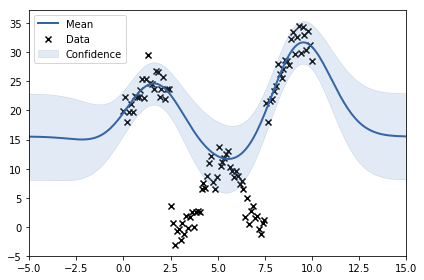

In [30]:

kern = GPy.kern.RBF(1) + GPy.kern.Bias(1)
model = GPy.models.GPRegression(gp_x, gp_y_4, kern + GPy.kern.Fixed(1, input_std))
model.kern.rbf.variance.set_prior(prior)
model.kern.rbf.lengthscale.set_prior(prior)
model.kern.fixed.variance.set_prior(prior)
model.kern.bias.variance.set_prior(prior)
model.optimize()
model.plot([-5, 15], predict_kw={"kern": model.kern.bias + model.kern.rbf})
model

The priors have effectively restricted the optimizer's ability to account for all the variance in the data using the RBF kernel.  As a result, the final model doesn't need to fit those points very well.  This is masked somewhat by the RBF's natural tendency 

GP_regression.,value,constraints,priors
sum.mlp.variance,1159.59526252,+ve,
sum.mlp.weight_variance,1.52337163831,+ve,
sum.mlp.bias_variance,506.094325087,+ve,
sum.fixed.variance,18.7382696696,+ve,"Ga(4e+02, 20)"
Gaussian_noise.variance,3.01763904397,+ve,


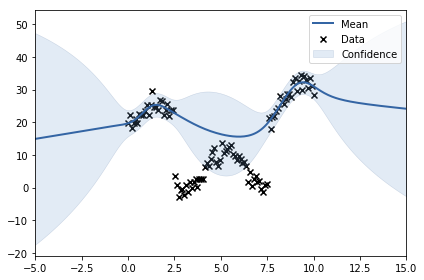

In [31]:
prior = GPy.priors.Gamma.from_EV(5, 1)
lengthscale_prior = GPy.priors.Gamma.from_EV(5, 1)

input_std = np.diag(np.power((-y_step + 1) * 20, 2))
kern = GPy.kern.MLP(1) + GPy.kern.Fixed(1, input_std)
model = GPy.models.GPRegression(gp_x, gp_y_4, kern)
model.kern.fixed.variance.set_prior(high_prior)
model.optimize()
model.plot([-5, 15], predict_kw={"kern": model.kern.mlp})
model